In [62]:
import pandas    as pd
import geopandas as geopd
import seaborn   as sea 
import matplotlib.pyplot as plt
from pyspark.sql       import SparkSession, dataframe
from pyspark.sql       import functions as f
from pyspark.sql.types import *
from Annotation import annotation

### Data & AI - PB Fast Learning - Ciência de Dados - 1/3

<div align="center">
    <img src='img/hierarquia.png' width="590px"/>
</div>

&nbsp;

Criando Seção no spark

In [63]:
spark = SparkSession.builder.master('local')\
    .appName('ProjetoSprint01')\
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

In [64]:
spark.sparkContext

<SparkContext master=local appName=ProjetoSprint01>

Carregando dados usando pyspark

In [65]:
# olist_customers_dataset
customers     = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_customers_dataset.csv')

# olist_geolocation_dataset
schemaGeo = StructType([ 
    StructField("geolocation_zip_code_prefix", StringType(), True),
    StructField("geolocation_lat", DoubleType(), True),
    StructField("geolocation_lng", DoubleType(), True),
    StructField("geolocation_city", StringType(), True),
    StructField("geolocation_state", StringType(), True)
])
geolocation   = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').schema(schemaGeo)\
        .load('dataset/olist_geolocation_dataset.csv')

# olist_order_payments_dataset
payments      = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_payments_dataset.csv')

# olist_orders_dataset
orders        = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_orders_dataset.csv')

# olist_order_items_dataset
order_items   = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_items_dataset.csv')

# olist_order_reviews_dataset
order_reviews = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_reviews_dataset.csv')

# olist_products_dataset
order_product = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_products_dataset.csv')

# olist_sellers_dataset

schemaSeller = StructType([
    StructField("seller_id", StringType(), True),
    StructField("seller_zip_code_prefix", StringType(), True),
    StructField("seller_city", StringType(), True),
    StructField("seller_state", StringType(), True)
])
sellers      = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').schema(schemaSeller)\
        .load('dataset/olist_sellers_dataset.csv')

# product_category_dataset
product_cat  = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/product_category_name_translation.csv')

Criando uma visão temporaria , pois usarei o sql do spark para fazer as questões

In [66]:
customers.createOrReplaceTempView('customers')
geolocation.createOrReplaceTempView('geolocation')
orders.createOrReplaceTempView('orders')
order_items.createOrReplaceTempView('order_items')
order_product.createOrReplaceTempView('order_product')
order_reviews.createOrReplaceTempView('order_reviews')
payments.createOrReplaceTempView('payments')
sellers.createOrReplaceTempView('sellers')
product_cat.createOrReplaceTempView('product_cat')

&nbsp;

## Analise

&nbsp;

### Quais são categorias com maior e menor receita dos ultimos 12 meses?

In [67]:
query = ''' select min(order_purchase_timestamp), max(order_purchase_timestamp) from orders;'''
spark.sql(query).show()

+-----------------------------+-----------------------------+
|min(order_purchase_timestamp)|max(order_purchase_timestamp)|
+-----------------------------+-----------------------------+
|          2016-09-04 21:15:19|          2018-10-17 17:30:18|
+-----------------------------+-----------------------------+



> O data vão de 2016 a 2019

Usando **Sql Spark** para fazer as questões \
Fazendo o `INNER JOIN` nas repestivas tabelas abaixo e com o `order_status!=cancelado` ,pois so será computado as vendas feitas(ou seja diferente de cancelado) assim consigo obter o valor real das Receitas de um produto, vender, estado.....
> Essa logica será feitas sobre as questões adiante que pedem `receitas` de algo

In [68]:
query = '''
SELECT product_category_name, SUM(payment_value) as Receita FROM order_items as o_i
    INNER JOIN order_product as o_p ON
        o_p.product_id = o_i.product_id
    INNER JOIN orders as or ON
        or.order_id = o_i.order_id
    INNER JOIN payments as pay ON
        pay.order_id = or.order_id

    WHERE order_status != 'canceled' and
        order_purchase_timestamp >= '2017-10-15 01:00:00' and
        order_purchase_timestamp <= '2018-10-17 17:30:18'
    GROUP BY product_category_name
    ORDER BY receita desc;
'''
data = spark.sql(query).toPandas()

Modificando a coluna `product_category_name` para torna-la mais legivel

In [69]:
# Tirar o `_` e colacando o ' ' (espaco vazio) usando o replace
data['product_category_name'] = data['product_category_name'].str.replace('_',' ')
# Deixando as primeiras letras de cada palavra maiuscula
data['product_category_name'] = data['product_category_name'].str.title()

Usarei seaborn e matplotlib para visualização pois ele renderiza no github, diferente do plotly

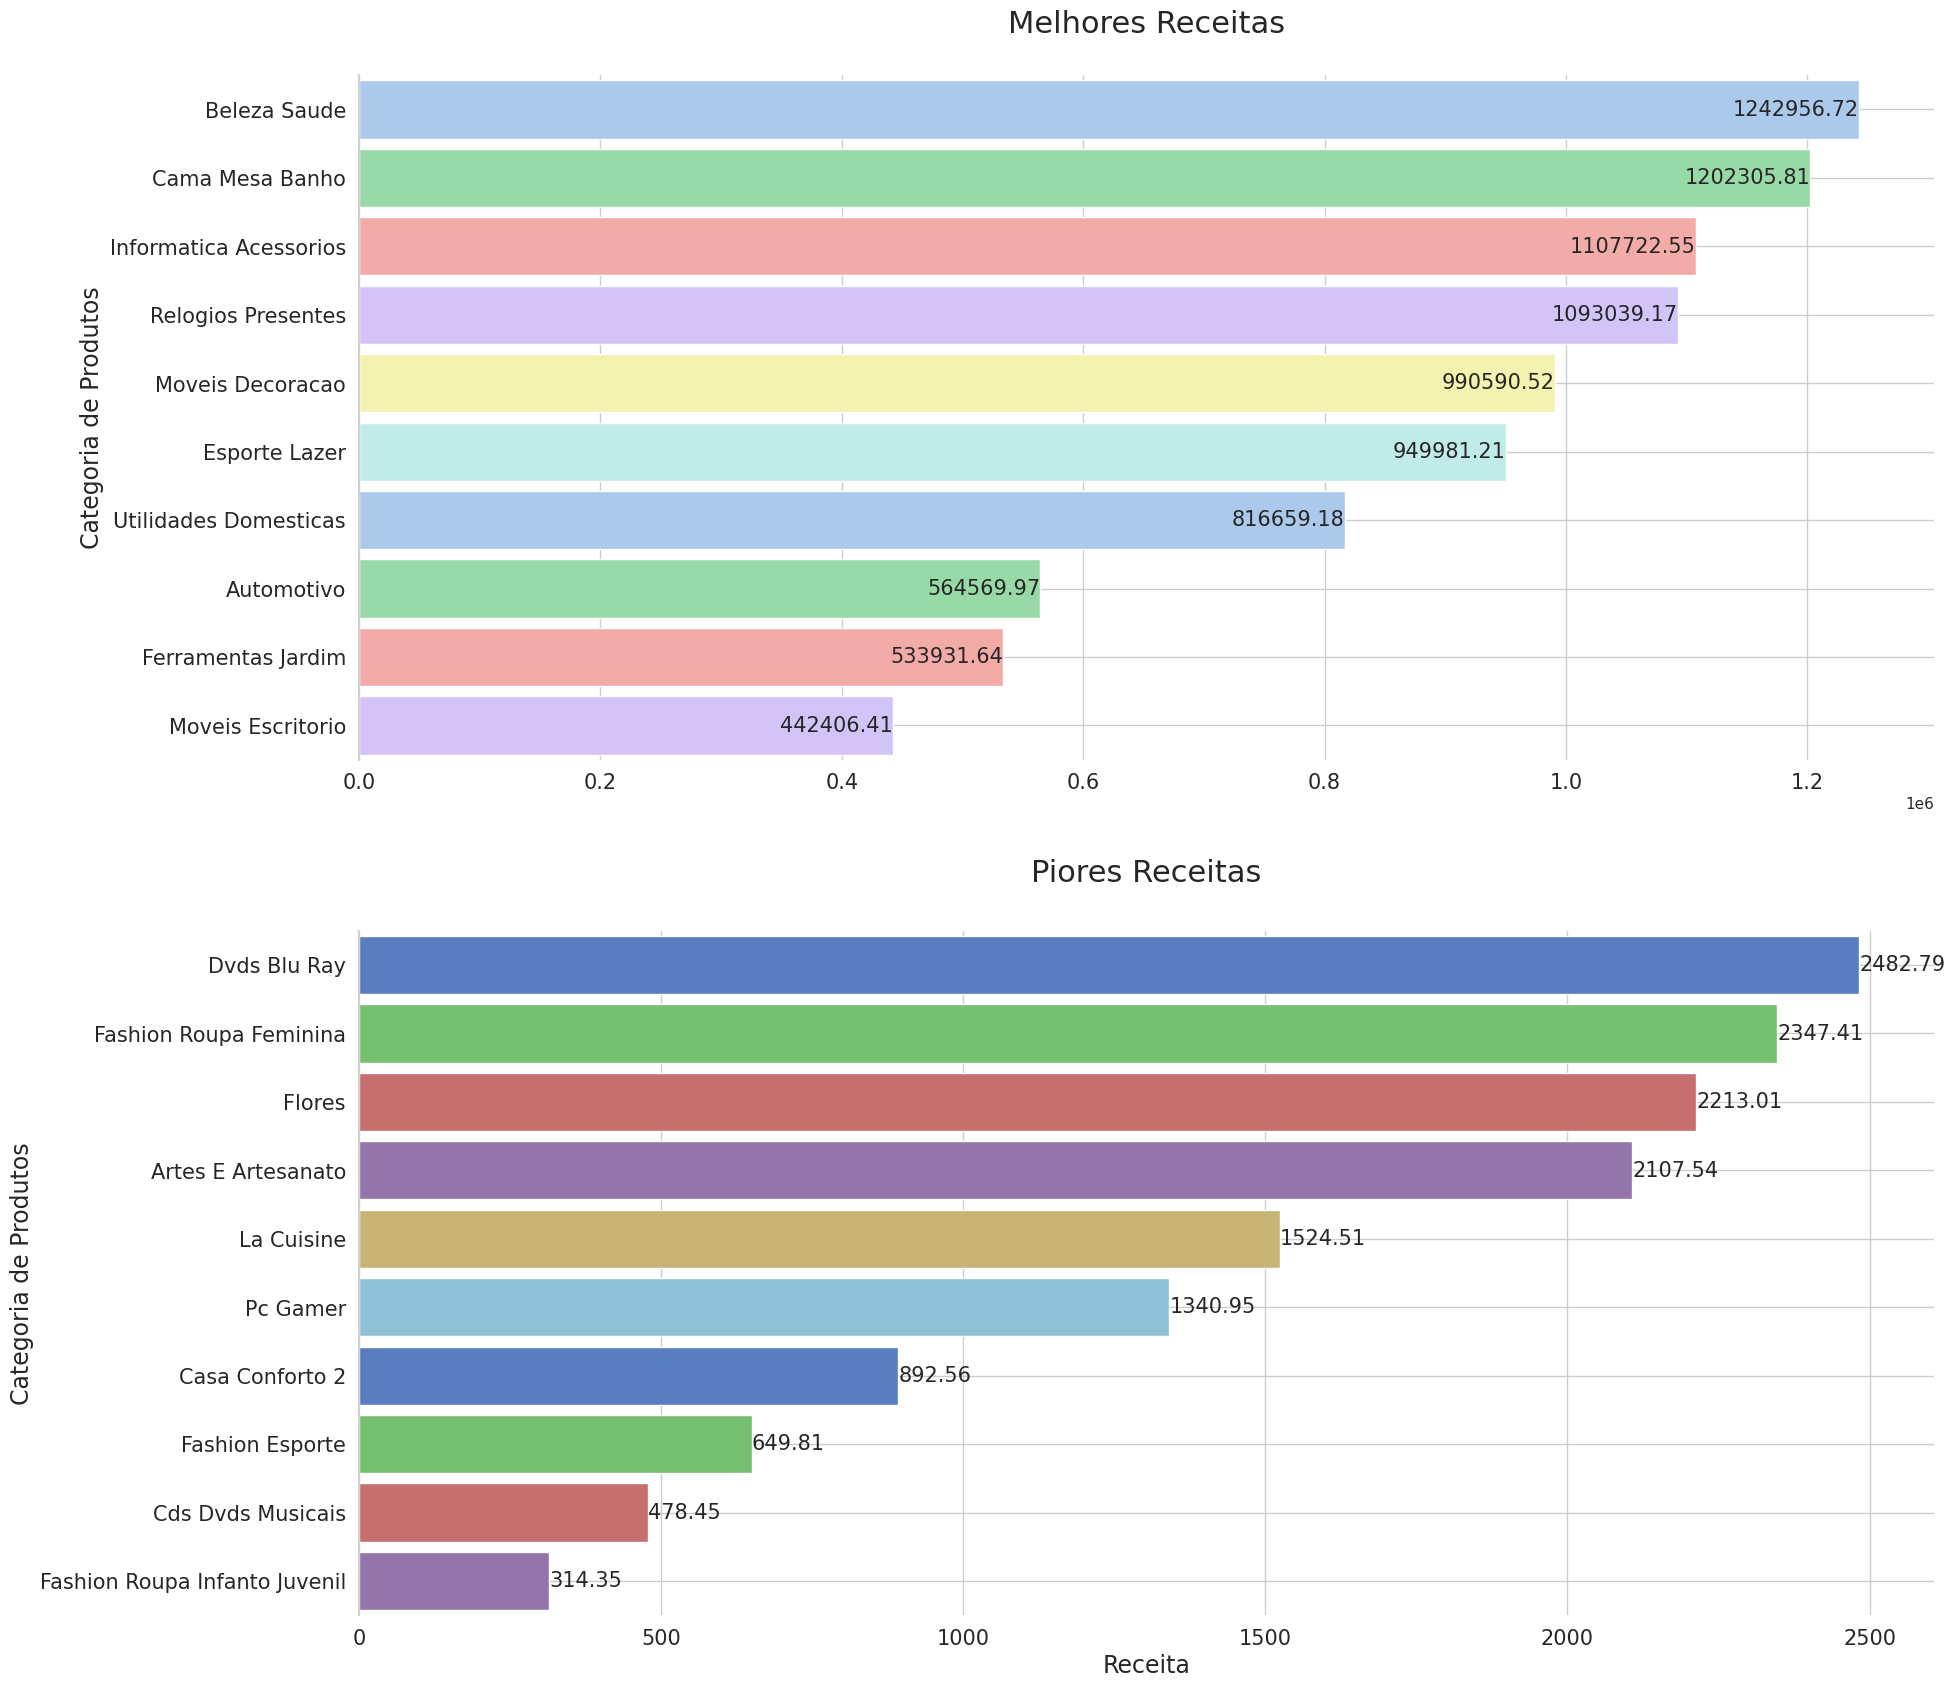

In [70]:
sea.set_theme(style="whitegrid")                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(18,20))
fig.subplots_adjust(hspace=0.25,right=1)        # Aumenta o espaço entre os graficos

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = data.iloc[0:10,:], 
    y='product_category_name', x='Receita', hue='product_category_name',width=0.85,
    palette=sea.color_palette('pastel6',n_colors=10), ax = ax[0], legend=False
)

#Modificando o Grafico 1
ax[0].set_title('Melhores Receitas',y=1.05,fontsize=22)
ax[0].set_ylabel('Categoria de Produtos',x=10,fontsize=17)
ax[0].set_xlabel('')
ax[0].spines[['right','top','bottom']].set_visible(False)
ax[0].tick_params('y', labelsize=15)
ax[0].tick_params('x', labelsize=15)         
ax[0].set_axisbelow(True)
ax[0].grid(True)

# Colocando o valor das receitas nas (barras)
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("%.2f" % p.get_width()),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=15)

# Grafico 2 = Piores receitas
barPiores = sea.barplot(data=data.iloc[63:76,:], 
    y='product_category_name', x='Receita', hue='product_category_name',width=0.85,
    palette =  sea.color_palette('muted6',n_colors=10), ax = ax[1], legend=False
)
for p in barPiores.patches:
    if p.get_width() != 0:
        barPiores.annotate("%.2f" % p.get_width(),xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'left', va = "center" ,size=15)

#Modificando o Grafico 2
ax[1].set_title('Piores Receitas',y=1.06,fontsize=22)       # Titulo 
ax[1].set_ylabel('Categoria de Produtos',x=10,fontsize=17)  # Modificando eixo y
ax[1].set_xlabel('Receita',fontsize=17)                     # Modificando eixo x
ax[1].spines[['right','top','bottom']].set_visible(False)   # Visibilidade das bordas
ax[1].tick_params('y', labelsize=15)  
ax[1].tick_params('x', labelsize=15)                        # Fonte do eixo y
ax[1].set_axisbelow(True)
ax[1].grid(True) 

plt.show()

&nbsp;

### Top 10 maiores sellers (maior receita)?

In [71]:
query = '''
SELECT (INITCAP(se.seller_city)|| '-' || se.seller_state) as seller ,
        ROUND(sum(payment_value),2) as receita FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id
    WHERE order_status != 'canceled'  
    GROUP BY seller
    ORDER BY receita desc limit 10; 
'''
data = spark.sql(query).toPandas()

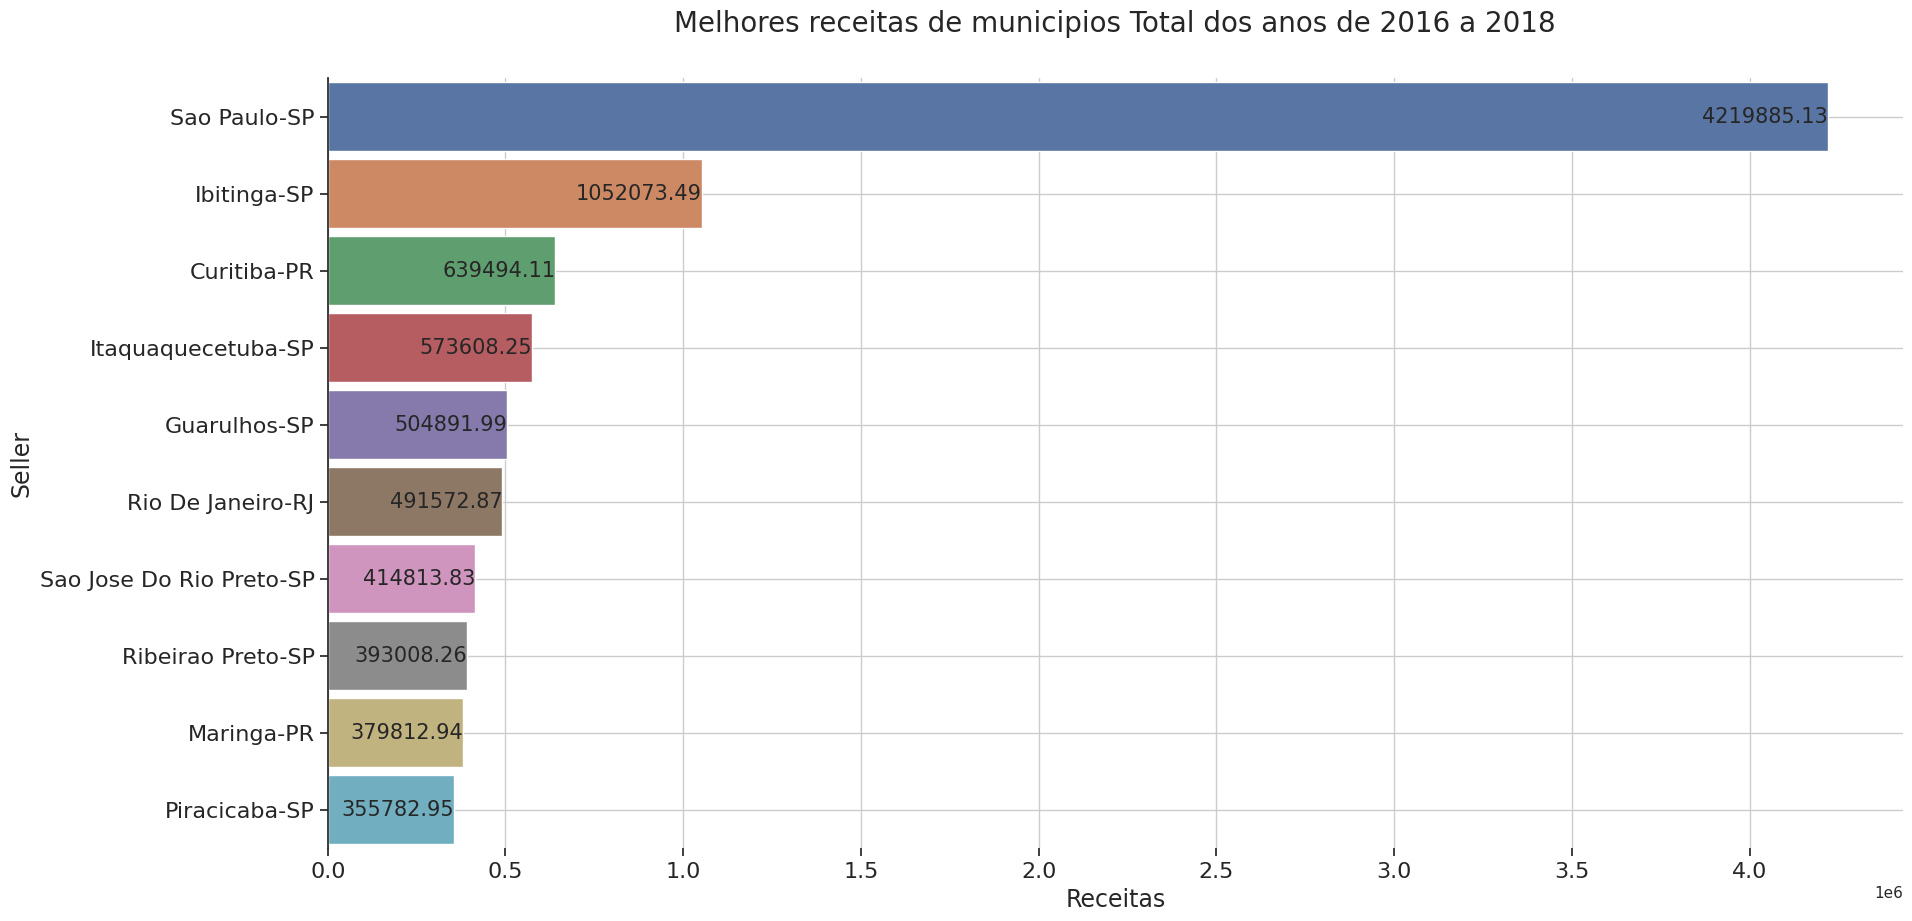

In [72]:
sea.set_theme(style="ticks")                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(18,10))
fig.subplots_adjust(hspace=0.25,right=1)        # Aumenta o espaço entre os graficos

# Grafico 1 = Melhores receitas
# Criando o grafico 1 com as melhores receitas
barMelhores = sea.barplot( data = data.iloc[0:10,:], 
    y='seller', x='receita', hue='seller', width=0.9, ax = ax, legend=False
)

#Modificando o Grafico 1
ax.set_title('Melhores receitas de municipios Total dos anos de 2016 a 2018',y=1.05,fontsize=20)
ax.set_ylabel('Seller',x=10,fontsize=17)
ax.set_xlabel('Receitas',fontsize=17)
ax.spines[['right','top','bottom']].set_visible(False)
ax.tick_params('y', labelsize=16)
ax.tick_params('x', labelsize=16)         
ax.set_axisbelow(True)
ax.grid(True)

# Colocando o valor das receitas nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("%.2f" % p.get_width()),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=15)

In [88]:
query = '''
SELECT seller_state, order_approved_at, payment_value FROM sellers AS se 
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id
'''
dataSql = spark.sql(query).na.drop()

Vou usar o spark para fazer essa operação, depois passarei para pandas para visualização

In [74]:
dataSpark = dataSql.groupby(
    [f.col('seller_state') ,f.year( f.col('order_approved_at') ).alias('ano')] )\
    .agg( 
        f.round(f.sum(f.col('payment_value'))).alias('receita') )\
    .orderBy( 
        f.col('receita').desc() )
dataPd = dataSpark.toPandas()

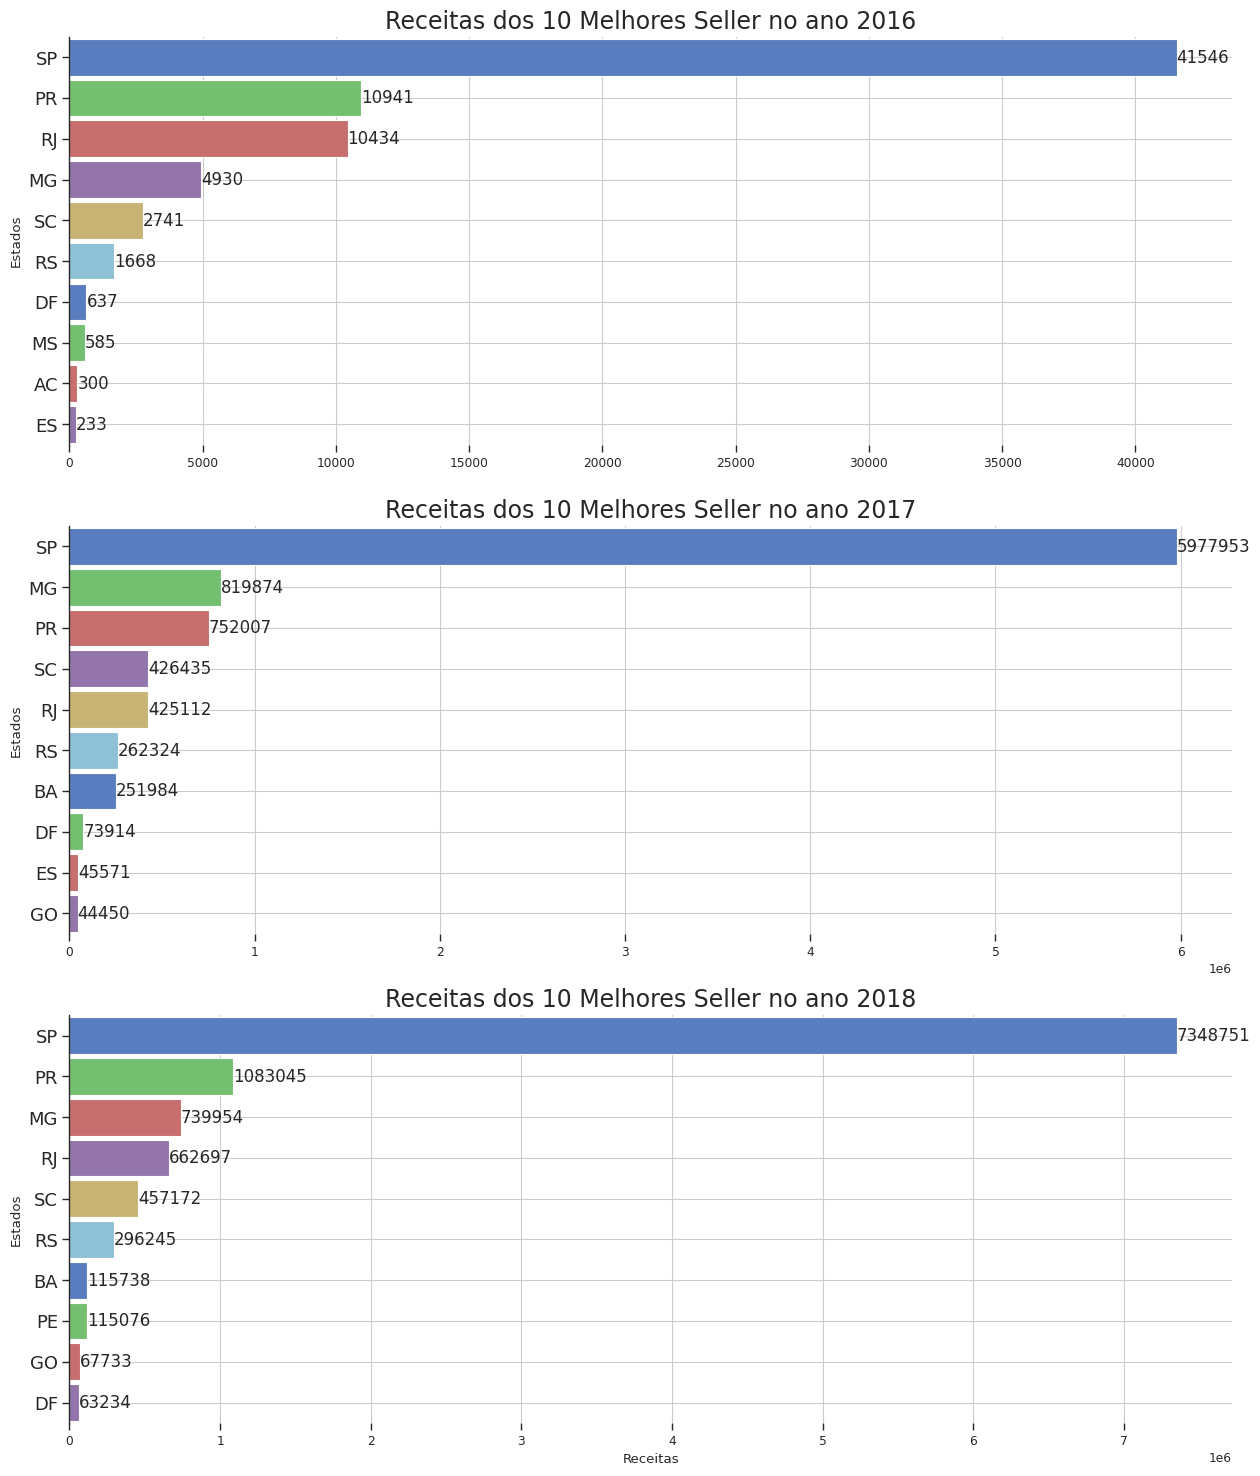

In [122]:
sea.set_theme('paper',style='ticks')
fig, ax = plt.subplots(ncols=1,nrows=3, figsize=(15,18))
fig.subplots_adjust(hspace=0.2)

for ano,axis in zip(range(2016, 2019),ax.flatten()):
    selecti = dataPd.loc[ dataPd['ano'] == ano ].iloc[0:10,:]

    bar = sea.barplot(
        data=selecti, x='receita', y='seller_state', hue='seller_state',ax=axis,
        palette=sea.color_palette('muted6',n_colors=10) , width=0.9
     )
    axis.set_title(f'Receitas dos 10 Melhores Seller no ano {ano}',fontsize=17)
    axis.set_ylabel('Estados')
    axis.set_xlabel('')
    axis.tick_params('y', labelsize=13)
    axis.spines[['right','top','bottom']].set_visible(False)
    axis.grid(True)

    for p in bar.patches:
        if p.get_width() != 0:
            bar.annotate(("%.0f" % p.get_width()),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
            xytext = (0, 0), textcoords= 'offset points', ha = 'left', va = "center" ,size=12)

axis.set_xlabel('Receitas',)
plt.show()

&nbsp;

#### Top 10 piores sellers?

&nbsp;

#### Existem sellers que vendem o mesmo produto? se sim quais são? Qual a variação de preço praticada entre os sellers?

Usarei o pandas para fazer o group by pois fica melhor de visualizar a tabela ou ela organiza melhor quando usa duas colunas para essa operação

In [ ]:
query = '''
SELECT seller_state, product_category_name,price FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        se.seller_id = o_i.seller_id
    INNER JOIN order_product AS op ON
        op.product_id = o_i.product_id
'''
data = spark.sql(query).toPandas()

In [ ]:
resultado = data.groupby(by=['seller_state', 'product_category_name'])['price'].mean().reset_index()
resultado.dropna(inplace=True)
resultado.head(3)

,seller_state,product_category_name,price
0,AC,livros_tecnicos,267.000000
1,AM,telefonia,392.333333
2,BA,alimentos_bebidas,124.535405


In [ ]:
def VarianciaDeLojas(data:pd.DataFrame):
    dicionario = {'States':[],'Produto':[],'Variação':[]}
    for enum ,statei in data.iterrows():
        for _ ,statej in data.iloc[enum:,:].iterrows():
            if (statei['seller_state'] != statej['seller_state']):
                if (statei['product_category_name'] == statej['product_category_name']):
                    dicionario['Produto'].append(statei['product_category_name'])
                    dicionario['States'].append(statei['seller_state'] +'-'+statej['seller_state'])
                    variacao =  ((statei['price'] - statej['price']))
                    dicionario['Variação'].append(variacao)
    return pd.DataFrame(dicionario)

&nbsp;

### Ouve inflação de preço dos produtos ?

In [ ]:
query = '''
SELECT * FROM order_product AS op
    INNER JOIN order_items AS o_i ON
        op.product_id = o_i.product_id;
'''
data = spark.sql(query).toPandas()

In [ ]:
data['year'] = pd.to_datetime(data['shipping_limit_date']).dt.year

In [ ]:
data

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,year
0,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017
1,e5f2d52b802189ee658865ca93d83a8f,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017
2,c777355d18b72b67abbeef9df44fd0fd,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018
3,7634da152a4610f1595efa32f14722fc,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018
4,ac6c3623068f30de03045865e4e10089,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,4aa6014eceb682077f9dc4bffebc05b0,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018
112646,32e07fd915822b0765e448c4dd74c828,informatica_acessorios,31.0,232.0,1.0,8950.0,45.0,26.0,38.0,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018
112647,72a30483855e2eafc67aee5dc2560482,esporte_lazer,43.0,869.0,1.0,967.0,21.0,24.0,19.0,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017
112648,9c422a519119dcad7575db5af1ba540e,informatica_acessorios,56.0,1306.0,1.0,100.0,20.0,20.0,20.0,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017
